# Velocity gradient time series from turbulence data

Lagrangian trajectories extracted from open-access *Johns Hopkins Turbulence Databases* (see http://turbulence.pha.jhu.edu/datasets.aspx)

- Forced isotropic turbulence 
- Channel flow

Use `inputs/turbulence/trajectories.ipynb` to generate trajectories stored in `npz` files. Run remotely on http://www.sciserver.org/.

Steps of this script, for each Lagrangian trajectory:

1. Load velocity gradient data
2. De-noise using wavelet hard-thresholding
3. Normalize maximum strain rate (maximum eigenvalue of strain rate tensor), and multiply time by the inverse of this factor.

In [10]:
import numpy as np
from scipy.interpolate import interp1d
import pywt

from ipywidgets import interactive, fixed
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 12]

folder = 'inputs/turbulence'

files = [
    't_gradU_channel_x0.0_y0.7_z0.0.npz',
    't_gradU_channel_x0.0_y0.8_z0.0.npz',
    't_gradU_channel_x0.0_y0.9_z0.0.npz',
    't_gradU_channel_x0.0_y-0.7_z0.0.npz',
    't_gradU_channel_x0.0_y-0.8_z0.0.npz',
    't_gradU_channel_x0.0_y-0.9_z0.0.npz'
]

output_file = 'inputs/turbulence/scenario_turbulence'

## Import velocity gradient data

In [3]:
times = []
gradUs = []
time_offset = 0.

for file in files:
    data = np.load(f'{folder}/{file}')
    times.append(data['t'])
    gradUs.append(data['gradU'])

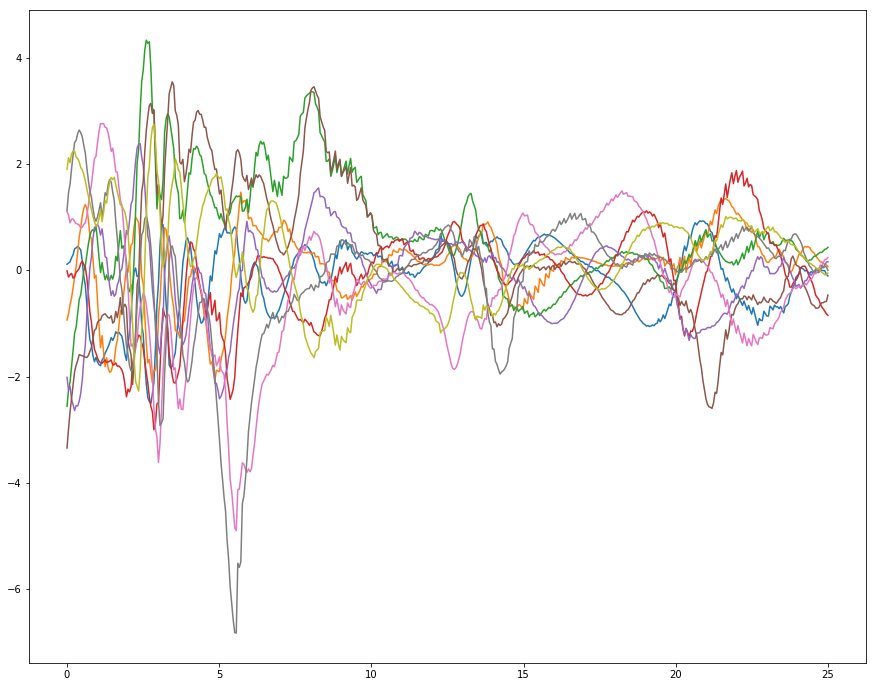

Max trace: 9.685754776000977e-08


In [4]:
plt.plot(times[0], gradUs[0].reshape(len(times[0]),9))
plt.show()
print(f"Max trace: {np.max(gradUs[0][:,0,0]+gradUs[0][:,1,1]+gradUs[0][:,2,2])}")

## Filter with wavelets

In [5]:
gradUs_denoised = []
wavelet = 'coif2'

for gradU in gradUs:

    coeffs = pywt.wavedec(gradU, wavelet, mode='antireflect', axis=0)
    for i in range(1,len(coeffs)):
        coeffs[i][np.abs(coeffs[i])<0.4] = 0
    #coeffs[-1] = np.zeros_like(coeffs[-1])
    #coeffs[-2] = np.zeros_like(coeffs[-2]) 

    gradUs_denoised.append(pywt.waverec(coeffs, wavelet, mode='antireflect', axis=0))

In [6]:
def zoom(tb, trajectory, line):
    figure, ax = plt.subplots(nrows=2)
    ax[0].plot(gradUs[trajectory][:,line], label='original')
    ax[0].plot(gradUs_denoised[trajectory][:,line], label='smoothed', linewidth=2)
    ax[1].plot(gradUs[trajectory][tb[0]:tb[1],line], label='original')
    ax[1].plot(gradUs_denoised[trajectory][tb[0]:tb[1],line], label='smoothed', linewidth=2)
    ax[1].set_title('Zoom')
    ax[0].axvline(tb[0])
    ax[0].axvline(tb[1])
    
    plt.show()


w = interactive(zoom, tb=widgets.IntRangeSlider(
                    value=[0, len(gradUs[0])-1],
                    description='Index range:',
                    min=0,
                    max=len(gradUs[0])-1, 
                    continuous_update=False
                    ),
                     trajectory=widgets.Dropdown(
                    options=list(range(len(gradUs))),
                    value=0,
                    description='Trajectory #:',
                    disabled=False,
                    ),
                    line=widgets.Dropdown(
                    options=[('xx, xy, xz', 0),('yx, yy, yz', 1),('zx, zy, zz', 2)],
                    value=0,
                    description='Line:',
                    disabled=False,
                    )
                
               )
w

interactive(children=(IntRangeSlider(value=(0, 499), continuous_update=False, description='Index range:', max=…

## Remove trace

In [7]:
print(f"Max trace: {np.max(gradUs_denoised[0][:,0,0]+gradUs_denoised[0][:,1,1]+gradUs_denoised[0][:,2,2])}")

for i, gradU in enumerate(gradUs_denoised):
    trgU = gradU[:,0,0] + gradU[:,1,1] + gradU[:,2,2]
    gradUs_denoised[i] = gradU - trgU[:, None, None]/3*np.full_like(gradU, np.eye(3))
    
print(f"Max trace: {np.max(gradUs_denoised[0][:,0,0]+gradUs_denoised[0][:,1,1]+gradUs_denoised[0][:,2,2])}")

Max trace: 0.44874447700133513
Max trace: 4.440892098500626e-16


## Analyse and normalize strain rate

In [12]:
gradUs = gradUs_denoised

gradUs_norm = []
times_norm = []
Es = []
Es_norm = []
Wis = []

# First pass to get max Wi
for gradU, time in zip(gradUs, times):

    # Get principal values for the strain
    D = 0.5*(gradU + np.transpose(gradU, axes=(0,2,1)))
    strains = np.linalg.eigvalsh(D)
    Es.append(np.amax(np.abs(strains), axis=1))
    Wis.append(np.amax(np.abs(strains)))

max_Wi = max(Wis)
print(f"Maximum strain rate: {max_Wi}")
# Second pass to normalise
for gradU, time, E in zip(gradUs, times, Es):

    gradUs_norm.append(gradU/max_Wi)
    times_norm.append(time*max_Wi)
    Es_norm.append(E/max_Wi)
    print(f"Normalised length of trajecotry: {time[-1]*max_Wi}")
    print(f"Max Weissenberg number: {np.amax(E/max_Wi)}")


Maximum strain rate: 7.37553438093922
Normalised length of trajecotry: 184.3883595234805
Max Weissenberg number: 0.6189871636525256
Normalised length of trajecotry: 184.3883595234805
Max Weissenberg number: 0.5435446365300296
Normalised length of trajecotry: 184.3883595234805
Max Weissenberg number: 1.0
Normalised length of trajecotry: 184.3883595234805
Max Weissenberg number: 0.5187931289306263
Normalised length of trajecotry: 184.3883595234805
Max Weissenberg number: 0.554922450547849
Normalised length of trajecotry: 184.3883595234805
Max Weissenberg number: 0.7367321526948006


In [13]:
def crop(tb, trajectory):
    figure, ax = plt.subplots(nrows=3)
    ax[0].plot(times_norm[trajectory], gradUs_norm[trajectory][:,0,0], c='#1d91c0', linewidth=2, label='xx')
    ax[0].plot(times_norm[trajectory], gradUs_norm[trajectory][:,0,1], c='#7fcdbb', linewidth=2, label='xy')
    ax[0].plot(times_norm[trajectory], gradUs_norm[trajectory][:,0,2], c='#c7e9b4', linewidth=2, label='xz')
    ax[0].plot(times_norm[trajectory], gradUs_norm[trajectory][:,1,0], c='#0c2c84', linewidth=2, label='yx')
    ax[0].legend()
    

    ax[1].plot(times_norm[trajectory][tb[0]:tb[1]], gradUs_norm[trajectory][tb[0]:tb[1],0,0], c='#1d91c0', linewidth=2, label='xx')
    ax[1].plot(times_norm[trajectory][tb[0]:tb[1]], gradUs_norm[trajectory][tb[0]:tb[1],0,1], c='#7fcdbb', linewidth=2, label='xy')
    ax[1].plot(times_norm[trajectory][tb[0]:tb[1]], gradUs_norm[trajectory][tb[0]:tb[1],0,2], c='#c7e9b4', linewidth=2, label='xz')
    ax[1].plot(times_norm[trajectory][tb[0]:tb[1]], gradUs_norm[trajectory][tb[0]:tb[1],1,0], c='#0c2c84', linewidth=2, label='yx')
    
    ax[1].set_title('Zoom')
    ax[0].axvline(times_norm[trajectory][tb[0]], c='r')
    ax[0].axvline(times_norm[trajectory][tb[1]], c='r')
    
    ax[2].semilogy(times_norm[trajectory][tb[0]:tb[1]], Es_norm[trajectory][tb[0]:tb[1]], c='#1d91c0', linewidth=2, label='xx')
    ax[2].set_title('Elongation rate')
    ax[2].axhline(1e-3, ls=':')
    
    plt.show()

#tab_contents
sliders = [widgets.IntRangeSlider(
                    value=[0, len(time)-1],
                    description='Index range:',
                    min=0,
                    max=len(time)-1, 
                    continuous_update=False
                    ) for time in times]

children = [interactive(crop, tb=slider, trajectory=fixed(i)) for i, slider in enumerate(sliders)]
tab = widgets.Tab()
tab.children = children
for i in range(len(children)):
    tab.set_title(i, str(i))
tab

## Record to files

In [14]:
for i, (time, gradU) in enumerate(zip(times_norm, gradUs_norm)):
    np.savez_compressed(f"{output_file}_{i}", t=time, gradU=gradU)